In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import json
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
%matplotlib inline
import os

In [0]:
train_json = "/content/drive/Shared drives/EECS545/unzipped_files/malaria/training.json"
test_json = "/content/drive/Shared drives/EECS545/unzipped_files/malaria/test.json"
with open(train_json, "r") as read_file:
  train_data = json.load(read_file)
with open(test_json, "r") as read_file:
  test_data = json.load(read_file)

In [0]:
print(len(train_data))
print(len(test_data))

1208
120


#Data Visualization

True


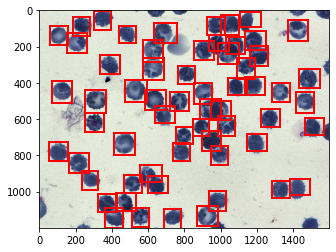

In [0]:
i = 1
cur_path = "/content/drive/Shared drives/EECS545/unzipped_files/malaria/"
img_path = train_data[i]['image']['pathname']
print(os.path.isfile(cur_path + img_path))
img = cv2.imread(cur_path + img_path)

fig, ax = plt.subplots(1)
ax.imshow(img[:,:,::-1])
color_label = ['r', 'b', 'g', 'c', 'm', 'k', 'y']
for anno in train_data[i]['objects']:
  label = anno['category']
  rmin = anno['bounding_box']['minimum']['r']
  cmin = anno['bounding_box']['minimum']['c']
  rmax = anno['bounding_box']['maximum']['r']
  cmax = anno['bounding_box']['maximum']['c']
  w = rmax - rmin
  h = cmax - cmin
  rect = patches.Rectangle((cmin, rmin), w, h,
                            linewidth=2, edgecolor=color_label[0], facecolor='none')
  ax.add_patch(rect)

plt.show()

# Generating Dataset

In [0]:
class_dict = {'red blood cell': 0, 'trophozoite': 1, 'schizont': 2, 'difficult': 3, 'ring': 4, 'leukocyte': 5, 'gametocyte': 6}

In [0]:
cur_path = "/content/drive/Shared drives/EECS545/unzipped_files/malaria/"
images = []
labels = []

for i in range(len(train_data)):
  if i % int(len(train_data)*0.1) == 0:
    print("{0:.2f}% done".format(i/len(train_data)*100))

  img_path = train_data[i]['image']['pathname']
  img = plt.imread(cur_path + img_path)
  for anno in train_data[i]['objects']:
    label = anno['category']
    rmin = anno['bounding_box']['minimum']['r']
    cmin = anno['bounding_box']['minimum']['c']
    rmax = anno['bounding_box']['maximum']['r']
    cmax = anno['bounding_box']['maximum']['c']
    
    obj_img = img[rmin:rmax, cmin:cmax]
    obj_img = cv2.resize(obj_img, (32, 32), 0, 0, cv2.INTER_LINEAR)
    obj_img = obj_img.astype(np.float32)
    obj_img = obj_img.flatten()
    images.append(obj_img)

    label = anno['category']
    labels.append(class_dict[label])

0.00% done
9.93% done
19.87% done
29.80% done
39.74% done
49.67% done
59.60% done
69.54% done
79.47% done
89.40% done
99.34% done


In [0]:
images = np.asarray(images).reshape(-1, 32, 32, 3)
print(images.shape)
labels = np.asarray(labels).reshape(-1, 1)
print(labels.shape)
np.save("/content/drive/Shared drives/EECS545/unzipped_files/malaria/X_train.npy", images)
np.save("/content/drive/Shared drives/EECS545/unzipped_files/malaria/y_train.npy", labels)

(80113, 32, 32, 3)
(80113, 1)


In [0]:
X_train = np.load("/content/drive/Shared drives/EECS545/unzipped_files/malaria/X_train.npy")
y_train = np.load("/content/drive/Shared drives/EECS545/unzipped_files/malaria/y_train.npy")
print(X_train.shape)
print(y_train.shape)

(80113, 32, 32, 3)
(80113, 1)


In [0]:
cur_path = "/content/drive/Shared drives/EECS545/unzipped_files/malaria/"
test_images = []
test_labels = []

for i in range(len(test_data)):
  if i % int(len(test_data)*0.1) == 0:
    print("{0:.2f}% done".format(i/len(test_data)*100))

  img_path = test_data[i]['image']['pathname']
  img = plt.imread(cur_path + img_path)
  for anno in test_data[i]['objects']:
    label = anno['category']
    rmin = anno['bounding_box']['minimum']['r']
    cmin = anno['bounding_box']['minimum']['c']
    rmax = anno['bounding_box']['maximum']['r']
    cmax = anno['bounding_box']['maximum']['c']
    
    obj_img = img[rmin:rmax, cmin:cmax]
    obj_img = cv2.resize(obj_img, (32, 32), 0, 0, cv2.INTER_LINEAR)
    obj_img = obj_img.astype(np.float32)
    obj_img = obj_img.flatten()
    test_images.append(obj_img)

    label = anno['category']
    test_labels.append(class_dict[label])

0.00% done
10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done


In [0]:
images = np.asarray(test_images).reshape(-1, 32, 32, 3)
print(images.shape)
labels = np.asarray(test_labels).reshape(-1, 1)
print(labels.shape)
np.save("/content/drive/Shared drives/EECS545/unzipped_files/malaria/X_test.npy", images)
np.save("/content/drive/Shared drives/EECS545/unzipped_files/malaria/y_test.npy", labels)

(5922, 32, 32, 3)
(5922, 1)


In [0]:
X_test = np.load("/content/drive/Shared drives/EECS545/unzipped_files/malaria/X_test.npy")
y_test = np.load("/content/drive/Shared drives/EECS545/unzipped_files/malaria/y_test.npy")
print(X_test.shape)
print(y_test.shape)

(5922, 32, 32, 3)
(5922, 1)


# Model

In [0]:
from __future__ import print_function, division, absolute_import
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
from torch.nn import init

In [0]:
class depthwise_separable_conv(nn.Module):
    def __init__(self, nin, nout, kernel_size, padding, bias=False):
        super(depthwise_separable_conv, self).__init__()
        self.depthwise = nn.Conv2d(nin, nin, kernel_size=kernel_size, padding=padding, groups=nin, bias=bias)
        self.pointwise = nn.Conv2d(nin, nout, kernel_size=1, bias=bias)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out


class Xception(nn.Module):
    def __init__(self, input_channel, num_classes=10):
        super(Xception, self).__init__()
        
        # Entry Flow
        self.entry_flow_1 = nn.Sequential(
            nn.Conv2d(input_channel, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        
        self.entry_flow_2 = nn.Sequential(
            depthwise_separable_conv(64, 128, 3, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            depthwise_separable_conv(128, 128, 3, 1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.entry_flow_2_residual = nn.Conv2d(64, 128, kernel_size=1, stride=2, padding=0)
        
        self.entry_flow_3 = nn.Sequential(
            nn.ReLU(True),
            depthwise_separable_conv(128, 256, 3, 1),
            nn.BatchNorm2d(256),
            
            nn.ReLU(True),
            depthwise_separable_conv(256, 256, 3, 1),
            nn.BatchNorm2d(256),
            
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.entry_flow_3_residual = nn.Conv2d(128, 256, kernel_size=1, stride=2, padding=0)

        self.entry_flow_4 = nn.Sequential(
            nn.ReLU(True),
            depthwise_separable_conv(256, 728, 3, 1),
            nn.BatchNorm2d(728),
            
            nn.ReLU(True),
            depthwise_separable_conv(728, 728, 3, 1),
            nn.BatchNorm2d(728),
            
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.entry_flow_4_residual = nn.Conv2d(256, 728, kernel_size=1, stride=2, padding=0)
        
        # Middle Flow
        self.middle_flow = nn.Sequential(
            nn.ReLU(True),
            depthwise_separable_conv(728, 728, 3, 1),
            nn.BatchNorm2d(728),
            
            nn.ReLU(True),
            depthwise_separable_conv(728, 728, 3, 1),
            nn.BatchNorm2d(728),
            
            nn.ReLU(True),
            depthwise_separable_conv(728, 728, 3, 1),
            nn.BatchNorm2d(728)
        )
        
        # Exit Flow
        self.exit_flow_1 = nn.Sequential(
            nn.ReLU(True),
            depthwise_separable_conv(728, 728, 3, 1),
            nn.BatchNorm2d(728),
            
            nn.ReLU(True),
            depthwise_separable_conv(728, 1024, 3, 1),
            nn.BatchNorm2d(1024),
            
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.exit_flow_1_residual = nn.Conv2d(728, 1024, kernel_size=1, stride=2, padding=0)
        self.exit_flow_2 = nn.Sequential(
            depthwise_separable_conv(1024, 1536, 3, 1),
            nn.BatchNorm2d(1536),
            nn.ReLU(True),
            
            depthwise_separable_conv(1536, 2048, 3, 1),
            nn.BatchNorm2d(2048),
            nn.ReLU(True)
        )
        
        self.linear = nn.Linear(2048, num_classes)
        
    def forward(self, x):
        entry_out1 = self.entry_flow_1(x)
        entry_out2 = self.entry_flow_2(entry_out1) + self.entry_flow_2_residual(entry_out1)
        entry_out3 = self.entry_flow_3(entry_out2) + self.entry_flow_3_residual(entry_out2)
        entry_out = self.entry_flow_4(entry_out3) + self.entry_flow_4_residual(entry_out3)
        
        middle_out = self.middle_flow(entry_out) + entry_out

        exit_out1 = self.exit_flow_1(middle_out) + self.exit_flow_1_residual(middle_out)
        exit_out2 = self.exit_flow_2(exit_out1)

        exit_avg_pool = F.adaptive_avg_pool2d(exit_out2, (1, 1))                
        exit_avg_pool_flat = exit_avg_pool.view(exit_avg_pool.size(0), -1)

        output = self.linear(exit_avg_pool_flat)
        
        return output

# Train

In [0]:
from __future__ import print_function
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import glob
import PIL
from PIL import Image
from torch.utils import data as D
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
import random
from torch.autograd import Variable
from sklearn.metrics import classification_report, f1_score

In [0]:
batch_size = 32
validation_ratio = 0.1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
class malaria_dataset(Dataset):
  def __init__(self, X, y, transform=None):
    self.images = X
    self.labels = y
    self.transform = transform

  def __getitem__(self, index):
    img = self.images[index]
    label = self.labels[index]

    if self.transform is not None:
      img = self.transform(img)

    return img, label

  def __len__(self):
    return len(self.images)

In [0]:
split_point = int(np.floor(len(X_train) * validation_ratio))
indices = np.arange(len(X_train))
np.random.seed(10)
np.random.shuffle(indices)
train_idx, valid_idx = indices[split_point:], indices[:split_point]

train_img = X_train[train_idx]
train_label = y_train[train_idx]
valid_img = X_train[valid_idx]
valid_label = y_train[valid_idx]
test_img = X_test
test_label = y_test

print("Train dataset")
print(train_img.shape)
print(train_label.shape)
for i in range(7):
  cur_idx = np.argwhere(train_label == i)
  print("{} label: {}".format(i, len(cur_idx)))

print("Valid dataset")
print(valid_img.shape)
print(valid_label.shape)
for i in range(7):
  cur_idx = np.argwhere(valid_label == i)
  print("{} label: {}".format(i, len(cur_idx)))

print("Test dataset")
print(test_img.shape)
print(test_label.shape)
for i in range(7):
  cur_idx = np.argwhere(test_label == i)
  print("{} label: {}".format(i, len(cur_idx)))

malaria_train = malaria_dataset(train_img, train_label,
                               transform=transforms.Compose([transforms.ToTensor()]))
malaria_valid = malaria_dataset(valid_img, valid_label,
                               transform=transforms.Compose([transforms.ToTensor()]))
malaria_test = malaria_dataset(test_img, test_label,
                               transform=transforms.Compose([transforms.ToTensor()]))

Train dataset
(72102, 32, 32, 3)
(72102, 1)
0 label: 69698
1 label: 1317
2 label: 165
3 label: 397
4 label: 308
5 label: 90
6 label: 127
Valid dataset
(8011, 32, 32, 3)
(8011, 1)
0 label: 7722
1 label: 156
2 label: 14
3 label: 44
4 label: 45
5 label: 13
6 label: 17
Test dataset
(5922, 32, 32, 3)
(5922, 1)
0 label: 5614
1 label: 111
2 label: 11
3 label: 5
4 label: 169
5 label: 0
6 label: 12


###1. SGD & CrossEntropyLoss

In [0]:
initial_lr = 0.001
num_epochs = 10

Xception_model = Xception(3, 7)
Xception_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Xception_model.parameters(), lr=initial_lr, momentum=0.9)

train_loader = torch.utils.data.DataLoader(
    malaria_train, batch_size=batch_size
)
valid_loader = torch.utils.data.DataLoader(
    malaria_valid, batch_size=batch_size
)
test_loader = torch.utils.data.DataLoader(
    malaria_test, batch_size=batch_size, shuffle=False
)

loss_history = []
train_acc = []
train_f1_score = []
val_acc = []
val_f1_score = []
for epoch in range(num_epochs):
    print("epoch {}".format(epoch+1))

    if epoch == 0:
        lr = initial_lr
    elif epoch % 2 == 0 and epoch != 0:
        lr *= 0.94
        optimizer = optim.SGD(Xception_model.parameters(), lr=lr, momentum=0.9)
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        # Data augmentation
        # Horizontal Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(2)
        # Vertical Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(3)
        # 90 rotation
        if torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3)
        # or 270 rotation
        elif torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3).flip(3)
        labels = labels.view(-1)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = Xception_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        show_period = 250
        if i % show_period == show_period-1:    # print every "show_period" mini-batches
            print('[%d, %5d] loss: %.7f' %
                  (epoch + 1, i + 1, running_loss / show_period))
            loss_history.append(running_loss)
            running_loss = 0.0
        
    #validation part
    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = Xception_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Training accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    train_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Training f1 score = {0:.3f}".format(f1))
    train_f1_score.append(f1)

    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(valid_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = Xception_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Validation accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    val_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Valid f1 score = {0:.3f}".format(f1))
    val_f1_score.append(f1)

print('Finished Training')

epoch 1
[1,   250] loss: 0.1722249
[1,   500] loss: 0.0812735
[1,   750] loss: 0.0777341
[1,  1000] loss: 0.0830471
[1,  1250] loss: 0.0693093
[1,  1500] loss: 0.0580522
[1,  1750] loss: 0.0714225
[1,  2000] loss: 0.0592313
[1,  2250] loss: 0.0543738
Training accuracy = 98.301%
0 label: Total=69698.0, correct=69641.0, acc=0.9991821860024678
1 label: Total=1317.0, correct=1132.0, acc=0.8595292331055429
2 label: Total=165.0, correct=0.0, acc=0.0
3 label: Total=397.0, correct=56.0, acc=0.14105793450881612
4 label: Total=308.0, correct=33.0, acc=0.10714285714285714
5 label: Total=90.0, correct=15.0, acc=0.16666666666666666
6 label: Total=127.0, correct=0.0, acc=0.0
Training f1 score = 0.344


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Validation accuracy = 98.190%
0 label: Total=7722.0, correct=7715.0, acc=0.9990934990934991
1 label: Total=156.0, correct=141.0, acc=0.9038461538461539
2 label: Total=14.0, correct=0.0, acc=0.0
3 label: Total=44.0, correct=8.0, acc=0.18181818181818182
4 label: Total=45.0, correct=2.0, acc=0.044444444444444446
5 label: Total=13.0, correct=0.0, acc=0.0
6 label: Total=17.0, correct=0.0, acc=0.0
Valid f1 score = 0.300
epoch 2
[2,   250] loss: 0.0539062
[2,   500] loss: 0.0452821
[2,   750] loss: 0.0531882
[2,  1000] loss: 0.0595546
[2,  1250] loss: 0.0540308
[2,  1500] loss: 0.0461029
[2,  1750] loss: 0.0540818
[2,  2000] loss: 0.0518750
[2,  2250] loss: 0.0435052
Training accuracy = 98.527%
0 label: Total=69698.0, correct=69648.0, acc=0.9992826193004103
1 label: Total=1317.0, correct=1183.0, acc=0.8982536066818527
2 label: Total=165.0, correct=0.0, acc=0.0
3 label: Total=397.0, correct=62.0, acc=0.1561712846347607
4 label: Total=308.0, correct=86.0, acc=0.2792207792207792
5 label: Total=9

In [0]:
# test part
correct = 0
total = 0
each_correct = np.zeros(7)
each_total = np.zeros(7)
total_predicted = None
total_labels = None
for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    labels = labels.view(-1)
    outputs = Xception_model(inputs)
    
    _, predicted = torch.max(outputs.data, 1)
    if total_predicted is None:
      total_predicted = predicted
      total_labels = labels
    else:
      total_predicted = torch.cat((total_predicted, predicted), axis=0)
      total_labels = torch.cat((total_labels, labels), axis=0)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    for i in range(7):
      cur_idx = (labels == i).nonzero()
      cur_label = labels[cur_idx]
      cur_predicted = predicted[cur_idx]
      each_total[i] += cur_label.size(0)
      each_correct[i] += (cur_predicted == cur_label).sum().item()
print("Test accuracy = {0:.3f}%".format(correct / total * 100))
for i in range(7):
  print("{} label: Total={}, correct={}, acc={}".format(i,
                                                        each_total[i],
                                                        each_correct[i],
                                                        each_correct[i]/each_total[i]))
f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
print("Test f1 score = {0:.3f}".format(f1))

Test accuracy = 95.846%
0 label: Total=5614.0, correct=5603.0, acc=0.9980406127538297
1 label: Total=111.0, correct=71.0, acc=0.6396396396396397
2 label: Total=11.0, correct=2.0, acc=0.18181818181818182
3 label: Total=5.0, correct=0.0, acc=0.0
4 label: Total=169.0, correct=0.0, acc=0.0
5 label: Total=0.0, correct=0.0, acc=nan
6 label: Total=12.0, correct=0.0, acc=0.0
Test f1 score = 0.257


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Text(0.5, 0, 'Epochs')

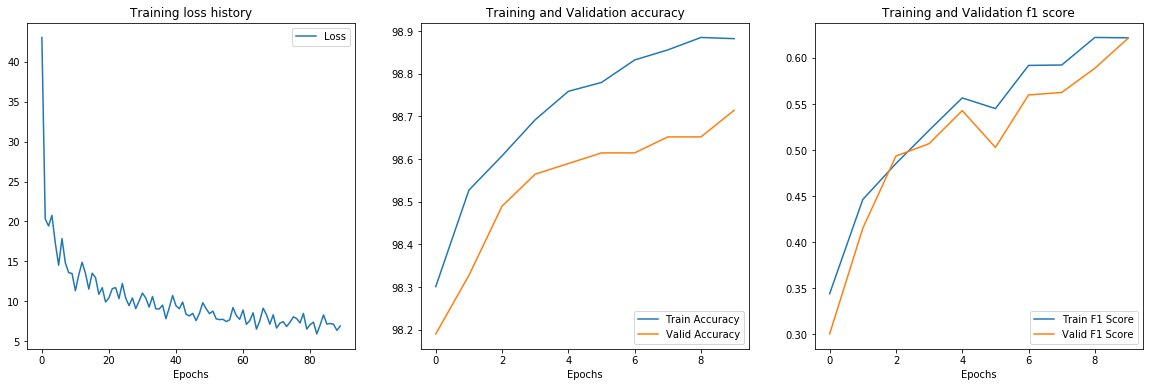

In [0]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].plot(loss_history, label='Loss')
axs[0].title.set_text("Training loss history")
axs[0].legend(loc="upper right")
axs[0].set_xlabel("Epochs")
axs[1].plot(train_acc, label='Train Accuracy')
axs[1].plot(val_acc, label='Valid Accuracy')
axs[1].title.set_text("Training and Validation accuracy")
axs[1].legend(loc="lower right")
axs[1].set_xlabel("Epochs")
axs[2].plot(train_f1_score, label='Train F1 Score')
axs[2].plot(val_f1_score, label='Valid F1 Score')
axs[2].title.set_text("Training and Validation f1 score")
axs[2].legend(loc="lower right")
axs[2].set_xlabel("Epochs")

###2. Adam & CrossEntropyLoss

In [0]:
initial_lr = 0.0001
num_epochs = 10

Xception_model = Xception(3, 7)
Xception_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Xception_model.parameters(), lr=initial_lr)

train_loader = torch.utils.data.DataLoader(
    malaria_train, batch_size=batch_size
)
valid_loader = torch.utils.data.DataLoader(
    malaria_valid, batch_size=batch_size
)
test_loader = torch.utils.data.DataLoader(
    malaria_test, batch_size=batch_size, shuffle=False
)

loss_history = []
train_acc = []
train_f1_score = []
val_acc = []
val_f1_score = []
for epoch in range(num_epochs):
    print("epoch {}".format(epoch+1))

    if epoch == 0:
        lr = initial_lr
    elif epoch % 2 == 0 and epoch != 0:
        lr *= 0.94
        optimizer = optim.Adam(Xception_model.parameters(), lr=lr)
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        # Data augmentation
        # Horizontal Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(2)
        # Vertical Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(3)
        # 90 rotation
        if torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3)
        # or 270 rotation
        elif torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3).flip(3)
        labels = labels.view(-1)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = Xception_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        show_period = 250
        if i % show_period == show_period-1:    # print every "show_period" mini-batches
            print('[%d, %5d] loss: %.7f' %
                  (epoch + 1, i + 1, running_loss / show_period))
            loss_history.append(running_loss)
            running_loss = 0.0
        
    #validation part
    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = Xception_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Training accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    train_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Training f1 score = {0:.3f}".format(f1))
    train_f1_score.append(f1)

    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(valid_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = Xception_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Validation accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    val_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Valid f1 score = {0:.3f}".format(f1))
    val_f1_score.append(f1)

print('Finished Training')

epoch 1
[1,   250] loss: 0.2029868
[1,   750] loss: 0.0822459
[1,  1000] loss: 0.0803001
[1,  1250] loss: 0.0723576
[1,  1500] loss: 0.0572217
[1,  1750] loss: 0.0681668
[1,  2000] loss: 0.0629305
[1,  2250] loss: 0.0569980
Training accuracy = 98.341%
0 label: Total=69698.0, correct=69637.0, acc=0.9991247955465006
1 label: Total=1317.0, correct=1174.0, acc=0.8914198936977981
2 label: Total=165.0, correct=0.0, acc=0.0
3 label: Total=397.0, correct=34.0, acc=0.08564231738035265
4 label: Total=308.0, correct=43.0, acc=0.1396103896103896
5 label: Total=90.0, correct=18.0, acc=0.2
6 label: Total=127.0, correct=0.0, acc=0.0
Training f1 score = 0.348


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Validation accuracy = 98.140%
0 label: Total=7722.0, correct=7714.0, acc=0.998963998963999
1 label: Total=156.0, correct=138.0, acc=0.8846153846153846
2 label: Total=14.0, correct=0.0, acc=0.0
3 label: Total=44.0, correct=4.0, acc=0.09090909090909091
4 label: Total=45.0, correct=3.0, acc=0.06666666666666667
5 label: Total=13.0, correct=3.0, acc=0.23076923076923078
6 label: Total=17.0, correct=0.0, acc=0.0
Valid f1 score = 0.338
epoch 2
[2,   250] loss: 0.0564908
[2,   500] loss: 0.0461271
[2,   750] loss: 0.0524989
[2,  1000] loss: 0.0564561
[2,  1250] loss: 0.0585003
[2,  1500] loss: 0.0499070
[2,  1750] loss: 0.0554890
[2,  2000] loss: 0.0537475
[2,  2250] loss: 0.0463549
Training accuracy = 98.483%
0 label: Total=69698.0, correct=69548.0, acc=0.997847857901231
1 label: Total=1317.0, correct=1181.0, acc=0.8967350037965072
2 label: Total=165.0, correct=1.0, acc=0.006060606060606061
3 label: Total=397.0, correct=127.0, acc=0.3198992443324937
4 label: Total=308.0, correct=120.0, acc=0.3

In [0]:
# test part
correct = 0
total = 0
each_correct = np.zeros(7)
each_total = np.zeros(7)
total_predicted = None
total_labels = None
for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    labels = labels.view(-1)
    outputs = Xception_model(inputs)
    
    _, predicted = torch.max(outputs.data, 1)
    if total_predicted is None:
      total_predicted = predicted
      total_labels = labels
    else:
      total_predicted = torch.cat((total_predicted, predicted), axis=0)
      total_labels = torch.cat((total_labels, labels), axis=0)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    for i in range(7):
      cur_idx = (labels == i).nonzero()
      cur_label = labels[cur_idx]
      cur_predicted = predicted[cur_idx]
      each_total[i] += cur_label.size(0)
      each_correct[i] += (cur_predicted == cur_label).sum().item()
print("Test accuracy = {0:.3f}%".format(correct / total * 100))
for i in range(7):
  print("{} label: Total={}, correct={}, acc={}".format(i,
                                                        each_total[i],
                                                        each_correct[i],
                                                        each_correct[i]/each_total[i]))
f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
print("Test f1 score = {0:.3f}".format(f1))

Test accuracy = 95.711%
0 label: Total=5614.0, correct=5560.0, acc=0.9903811898824367
1 label: Total=111.0, correct=94.0, acc=0.8468468468468469
2 label: Total=11.0, correct=2.0, acc=0.18181818181818182
3 label: Total=5.0, correct=0.0, acc=0.0
4 label: Total=169.0, correct=12.0, acc=0.07100591715976332
5 label: Total=0.0, correct=0.0, acc=nan
6 label: Total=12.0, correct=0.0, acc=0.0
Test f1 score = 0.274


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Text(0.5, 0, 'Epochs')

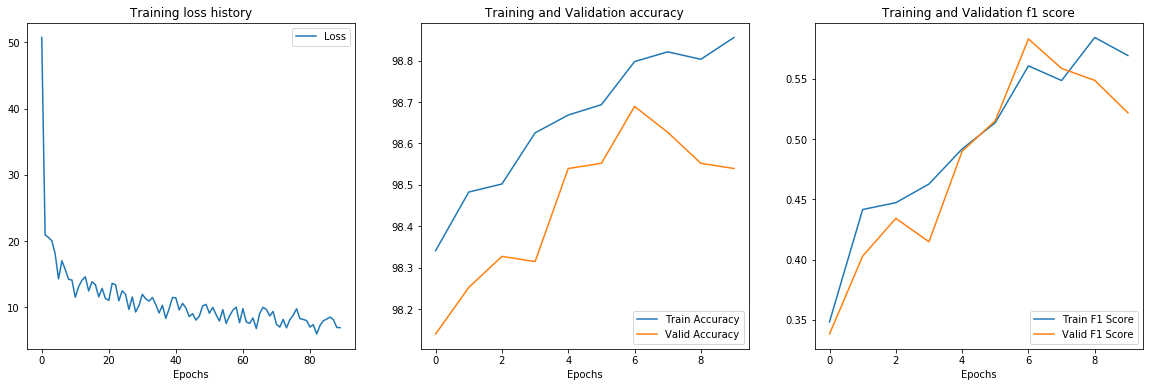

In [0]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].plot(loss_history, label='Loss')
axs[0].title.set_text("Training loss history")
axs[0].legend(loc="upper right")
axs[0].set_xlabel("Epochs")
axs[1].plot(train_acc, label='Train Accuracy')
axs[1].plot(val_acc, label='Valid Accuracy')
axs[1].title.set_text("Training and Validation accuracy")
axs[1].legend(loc="lower right")
axs[1].set_xlabel("Epochs")
axs[2].plot(train_f1_score, label='Train F1 Score')
axs[2].plot(val_f1_score, label='Valid F1 Score')
axs[2].title.set_text("Training and Validation f1 score")
axs[2].legend(loc="lower right")
axs[2].set_xlabel("Epochs")

In [0]:
def one_hot_embedding(labels, num_classes):
    '''Embedding labels to one-hot form.
    Args:
      labels: (LongTensor) class labels, sized [N,].
      num_classes: (int) number of classes.
    Returns:
      (tensor) encoded labels, sized [N,#classes].
    '''
    y = torch.eye(num_classes)  # [D,D]
    return y[labels]            # [N,D]


class FocalLoss(nn.Module):
    def __init__(self, num_classes=7):
        super(FocalLoss, self).__init__()
        self.num_classes = num_classes

    def focal_loss(self, x, y):
        '''Focal loss.
        Args:
          x: (tensor) sized [N,D].
          y: (tensor) sized [N,].
        Return:
          (tensor) focal loss.
        '''
        alpha = 0.25
        gamma = 2

        t = one_hot_embedding(y.data.cpu(), 1+self.num_classes)  # [N,21]
        t = t[:,1:]  # exclude background
        t = Variable(t).cuda()  # [N,20]

        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)         # pt = p if t > 0 else 1-p
        w = alpha*t + (1-alpha)*(1-t)  # w = alpha if t > 0 else 1-alpha
        w = w * (1-pt).pow(gamma)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)

    def focal_loss_alt(self, x, y):
        '''Focal loss alternative.
        Args:
          x: (tensor) sized [N,D].
          y: (tensor) sized [N,].
        Return:
          (tensor) focal loss.
        '''
        alpha = 0.25
        eps = 1e-8

        t = one_hot_embedding(y.data.cpu(), self.num_classes)
        t = Variable(t).cuda()

        xt = x*(2*t-1)  # xt = x if t > 0 else -x
        pt = (2*xt+1).sigmoid()

        w = alpha*t + (1-alpha)*(1-t)
        loss = -w*pt.log() / 2
        return loss.sum()

    def forward(self, outputs, labels):
        loss = self.focal_loss_alt(outputs, labels)
        return loss

###3. Adam & Focal Loss

In [0]:
initial_lr = 0.0001
num_epochs = 10

Xception_model = Xception(3, 7)
Xception_model.to(device)
criterion = FocalLoss(num_classes=7)
optimizer = optim.Adam(Xception_model.parameters(), lr=initial_lr)

train_loader = torch.utils.data.DataLoader(
    malaria_train, batch_size=batch_size
)
valid_loader = torch.utils.data.DataLoader(
    malaria_valid, batch_size=batch_size
)
test_loader = torch.utils.data.DataLoader(
    malaria_test, batch_size=batch_size, shuffle=False
)

loss_history = []
train_acc = []
train_f1_score = []
val_acc = []
val_f1_score = []
for epoch in range(num_epochs):
    print("epoch {}".format(epoch+1))

    if epoch == 0:
        lr = initial_lr
    elif epoch % 2 == 0 and epoch != 0:
        lr *= 0.94
        optimizer = optim.Adam(Xception_model.parameters(), lr=lr)
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        # Data augmentation
        # Horizontal Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(2)
        # Vertical Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(3)
        # 90 rotation
        if torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3)
        # or 270 rotation
        elif torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3).flip(3)
        labels = labels.view(-1)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = Xception_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        show_period = 250
        if i % show_period == show_period-1:    # print every "show_period" mini-batches
            print('[%d, %5d] loss: %.7f' %
                  (epoch + 1, i + 1, running_loss / show_period))
            loss_history.append(running_loss)
            running_loss = 0.0
        
    #validation part
    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = Xception_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Training accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    train_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Training f1 score = {0:.3f}".format(f1))
    train_f1_score.append(f1)

    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(valid_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = Xception_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Validation accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    val_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Valid f1 score = {0:.3f}".format(f1))
    val_f1_score.append(f1)

print('Finished Training')

epoch 1
[1,   250] loss: 1.9535882
[1,   500] loss: 0.5874239
[1,   750] loss: 0.5889885
[1,  1000] loss: 0.5309648
[1,  1250] loss: 0.4740282
[1,  1500] loss: 0.3972038
[1,  1750] loss: 0.4411571
[1,  2000] loss: 0.3993671
[1,  2250] loss: 0.3375032
Training accuracy = 98.197%
0 label: Total=69698.0, correct=69593.0, acc=0.9984935005308617
1 label: Total=1317.0, correct=1151.0, acc=0.873955960516325
2 label: Total=165.0, correct=0.0, acc=0.0
3 label: Total=397.0, correct=24.0, acc=0.060453400503778336
4 label: Total=308.0, correct=34.0, acc=0.11038961038961038
5 label: Total=90.0, correct=0.0, acc=0.0
6 label: Total=127.0, correct=0.0, acc=0.0
Training f1 score = 0.286


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Validation accuracy = 98.040%
0 label: Total=7722.0, correct=7711.0, acc=0.9985754985754985
1 label: Total=156.0, correct=137.0, acc=0.8782051282051282
2 label: Total=14.0, correct=0.0, acc=0.0
3 label: Total=44.0, correct=2.0, acc=0.045454545454545456
4 label: Total=45.0, correct=4.0, acc=0.08888888888888889
5 label: Total=13.0, correct=0.0, acc=0.0
6 label: Total=17.0, correct=0.0, acc=0.0
Valid f1 score = 0.280
epoch 2
[2,   250] loss: 0.3619148
[2,   500] loss: 0.3005836
[2,   750] loss: 0.3089587
[2,  1000] loss: 0.3597952
[2,  1250] loss: 0.3601021
[2,  1500] loss: 0.3230505
[2,  1750] loss: 0.3514001
[2,  2000] loss: 0.3041325
[2,  2250] loss: 0.2863176
Training accuracy = 98.448%
0 label: Total=69698.0, correct=69640.0, acc=0.999167838388476
1 label: Total=1317.0, correct=1196.0, acc=0.9081245254365984
2 label: Total=165.0, correct=0.0, acc=0.0
3 label: Total=397.0, correct=59.0, acc=0.1486146095717884
4 label: Total=308.0, correct=25.0, acc=0.08116883116883117
5 label: Total=9

In [0]:
# test part
correct = 0
total = 0
each_correct = np.zeros(7)
each_total = np.zeros(7)
total_predicted = None
total_labels = None
for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    labels = labels.view(-1)
    outputs = Xception_model(inputs)
    
    _, predicted = torch.max(outputs.data, 1)
    if total_predicted is None:
      total_predicted = predicted
      total_labels = labels
    else:
      total_predicted = torch.cat((total_predicted, predicted), axis=0)
      total_labels = torch.cat((total_labels, labels), axis=0)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    for i in range(7):
      cur_idx = (labels == i).nonzero()
      cur_label = labels[cur_idx]
      cur_predicted = predicted[cur_idx]
      each_total[i] += cur_label.size(0)
      each_correct[i] += (cur_predicted == cur_label).sum().item()
print("Test accuracy = {0:.3f}%".format(correct / total * 100))
for i in range(7):
  print("{} label: Total={}, correct={}, acc={}".format(i,
                                                        each_total[i],
                                                        each_correct[i],
                                                        each_correct[i]/each_total[i]))
f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
print("Test f1 score = {0:.3f}".format(f1))

Test accuracy = 96.403%
0 label: Total=5614.0, correct=5605.0, acc=0.9983968649804061
1 label: Total=111.0, correct=85.0, acc=0.7657657657657657
2 label: Total=11.0, correct=1.0, acc=0.09090909090909091
3 label: Total=5.0, correct=0.0, acc=0.0
4 label: Total=169.0, correct=17.0, acc=0.10059171597633136
5 label: Total=0.0, correct=0.0, acc=nan
6 label: Total=12.0, correct=1.0, acc=0.08333333333333333
Test f1 score = 0.298


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Text(0.5, 0, 'Epochs')

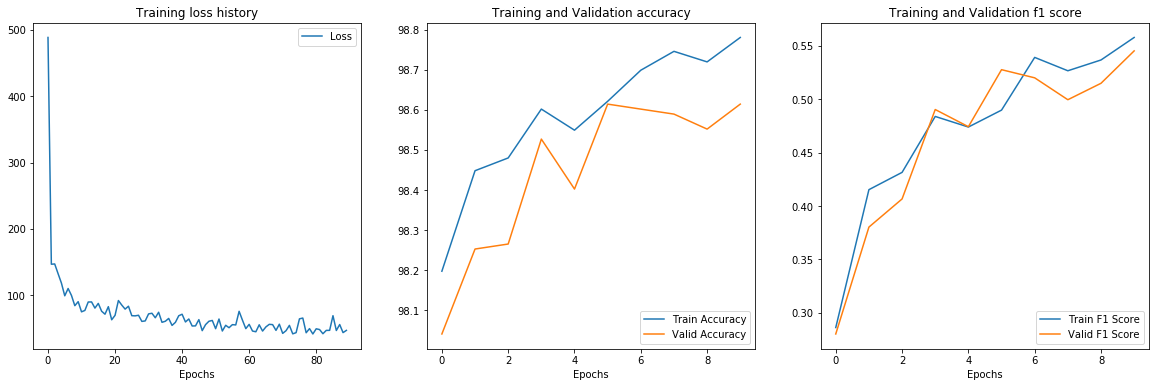

In [0]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].plot(loss_history, label='Loss')
axs[0].title.set_text("Training loss history")
axs[0].legend(loc="upper right")
axs[0].set_xlabel("Epochs")
axs[1].plot(train_acc, label='Train Accuracy')
axs[1].plot(val_acc, label='Valid Accuracy')
axs[1].title.set_text("Training and Validation accuracy")
axs[1].legend(loc="lower right")
axs[1].set_xlabel("Epochs")
axs[2].plot(train_f1_score, label='Train F1 Score')
axs[2].plot(val_f1_score, label='Valid F1 Score')
axs[2].title.set_text("Training and Validation f1 score")
axs[2].legend(loc="lower right")
axs[2].set_xlabel("Epochs")

###4. Adam & Focal Loss, Learning rate = 1e-6

In [0]:
initial_lr = 1e-6
num_epochs = 10

Xception_model = Xception(3, 7)
Xception_model.to(device)
criterion = FocalLoss(num_classes=7)
optimizer = optim.Adam(Xception_model.parameters(), lr=initial_lr)

train_loader = torch.utils.data.DataLoader(
    malaria_train, batch_size=batch_size
)
valid_loader = torch.utils.data.DataLoader(
    malaria_valid, batch_size=batch_size
)
test_loader = torch.utils.data.DataLoader(
    malaria_test, batch_size=batch_size, shuffle=False
)

loss_history = []
train_acc = []
train_f1_score = []
val_acc = []
val_f1_score = []
for epoch in range(num_epochs):
    print("epoch {}".format(epoch+1))

    if epoch == 0:
        lr = initial_lr
    elif epoch % 2 == 0 and epoch != 0:
        lr *= 0.94
        optimizer = optim.Adam(Xception_model.parameters(), lr=lr)
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        # Data augmentation
        # Horizontal Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(2)
        # Vertical Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(3)
        # 90 rotation
        if torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3)
        # or 270 rotation
        elif torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3).flip(3)
        labels = labels.view(-1)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = Xception_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        show_period = 250
        if i % show_period == show_period-1:    # print every "show_period" mini-batches
            print('[%d, %5d] loss: %.7f' %
                  (epoch + 1, i + 1, running_loss / show_period))
            loss_history.append(running_loss)
            running_loss = 0.0
        
    #validation part
    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = Xception_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Training accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    train_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Training f1 score = {0:.3f}".format(f1))
    train_f1_score.append(f1)

    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(valid_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = Xception_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Validation accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    val_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Valid f1 score = {0:.3f}".format(f1))
    val_f1_score.append(f1)

print('Finished Training')

epoch 1
[1,   250] loss: 27.3254316
[1,   500] loss: 20.0569079
[1,   750] loss: 15.1276870
[1,  1000] loss: 11.7893657
[1,  1250] loss: 9.3699595
[1,  1500] loss: 7.5891935
[1,  1750] loss: 6.3160397
[1,  2000] loss: 5.3179893
[1,  2250] loss: 4.5213047
Training accuracy = 96.667%
0 label: Total=69698.0, correct=69645.0, acc=0.999239576458435
1 label: Total=1317.0, correct=16.0, acc=0.012148823082763858
2 label: Total=165.0, correct=15.0, acc=0.09090909090909091
3 label: Total=397.0, correct=23.0, acc=0.05793450881612091
4 label: Total=308.0, correct=0.0, acc=0.0
5 label: Total=90.0, correct=0.0, acc=0.0
6 label: Total=127.0, correct=0.0, acc=0.0
Training f1 score = 0.175


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Validation accuracy = 96.380%
0 label: Total=7722.0, correct=7717.0, acc=0.9993524993524994
1 label: Total=156.0, correct=1.0, acc=0.00641025641025641
2 label: Total=14.0, correct=1.0, acc=0.07142857142857142
3 label: Total=44.0, correct=2.0, acc=0.045454545454545456
4 label: Total=45.0, correct=0.0, acc=0.0
5 label: Total=13.0, correct=0.0, acc=0.0
6 label: Total=17.0, correct=0.0, acc=0.0
Valid f1 score = 0.165
epoch 2
[2,   250] loss: 3.9020857
[2,   500] loss: 3.3348434
[2,   750] loss: 3.0283380
[2,  1000] loss: 2.6969565
[2,  1250] loss: 2.3959259
[2,  1500] loss: 2.1327059
[2,  1750] loss: 2.0021308
[2,  2000] loss: 1.8309305
[2,  2250] loss: 1.6350877
Training accuracy = 96.824%
0 label: Total=69698.0, correct=69682.0, acc=0.9997704381761313
1 label: Total=1317.0, correct=104.0, acc=0.07896735003796507
2 label: Total=165.0, correct=9.0, acc=0.05454545454545454
3 label: Total=397.0, correct=17.0, acc=0.042821158690176324
4 label: Total=308.0, correct=0.0, acc=0.0
5 label: Total=

In [0]:
# test part
correct = 0
total = 0
each_correct = np.zeros(7)
each_total = np.zeros(7)
total_predicted = None
total_labels = None
for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    labels = labels.view(-1)
    outputs = Xception_model(inputs)
    
    _, predicted = torch.max(outputs.data, 1)
    if total_predicted is None:
      total_predicted = predicted
      total_labels = labels
    else:
      total_predicted = torch.cat((total_predicted, predicted), axis=0)
      total_labels = torch.cat((total_labels, labels), axis=0)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    for i in range(7):
      cur_idx = (labels == i).nonzero()
      cur_label = labels[cur_idx]
      cur_predicted = predicted[cur_idx]
      each_total[i] += cur_label.size(0)
      each_correct[i] += (cur_predicted == cur_label).sum().item()
print("Test accuracy = {0:.3f}%".format(correct / total * 100))
for i in range(7):
  print("{} label: Total={}, correct={}, acc={}".format(i,
                                                        each_total[i],
                                                        each_correct[i],
                                                        each_correct[i]/each_total[i]))
f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
print("Test f1 score = {0:.3f}".format(f1))

Test accuracy = 95.424%
0 label: Total=5614.0, correct=5611.0, acc=0.9994656216601354
1 label: Total=111.0, correct=40.0, acc=0.36036036036036034
2 label: Total=11.0, correct=0.0, acc=0.0
3 label: Total=5.0, correct=0.0, acc=0.0
4 label: Total=169.0, correct=0.0, acc=0.0
5 label: Total=0.0, correct=0.0, acc=nan
6 label: Total=12.0, correct=0.0, acc=0.0
Test f1 score = 0.236


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(0.5, 0, 'Epochs')

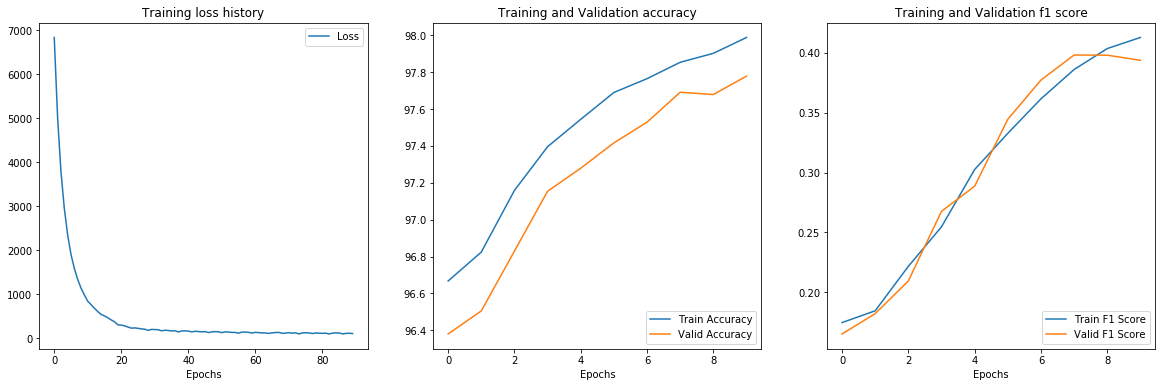

In [0]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].plot(loss_history, label='Loss')
axs[0].title.set_text("Training loss history")
axs[0].legend(loc="upper right")
axs[0].set_xlabel("Epochs")
axs[1].plot(train_acc, label='Train Accuracy')
axs[1].plot(val_acc, label='Valid Accuracy')
axs[1].title.set_text("Training and Validation accuracy")
axs[1].legend(loc="lower right")
axs[1].set_xlabel("Epochs")
axs[2].plot(train_f1_score, label='Train F1 Score')
axs[2].plot(val_f1_score, label='Valid F1 Score')
axs[2].title.set_text("Training and Validation f1 score")
axs[2].legend(loc="lower right")
axs[2].set_xlabel("Epochs")

###5. Adam & Focal Loss, Without data augmentation

In [0]:
initial_lr = 0.0001
num_epochs = 10

Xception_model = Xception(3, 7)
Xception_model.to(device)
criterion = FocalLoss(num_classes=7)
optimizer = optim.Adam(Xception_model.parameters(), lr=initial_lr)

train_loader = torch.utils.data.DataLoader(
    malaria_train, batch_size=batch_size
)
valid_loader = torch.utils.data.DataLoader(
    malaria_valid, batch_size=batch_size
)
test_loader = torch.utils.data.DataLoader(
    malaria_test, batch_size=batch_size, shuffle=False
)

loss_history = []
train_acc = []
train_f1_score = []
val_acc = []
val_f1_score = []
for epoch in range(num_epochs):
    print("epoch {}".format(epoch+1))

    if epoch == 0:
        lr = initial_lr
    elif epoch % 2 == 0 and epoch != 0:
        lr *= 0.94
        optimizer = optim.Adam(Xception_model.parameters(), lr=lr)
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        # Data augmentation
        # # Horizontal Flip
        # if torch.rand(1).item() > 0.5:
        #   inputs = inputs.flip(2)
        # # Vertical Flip
        # if torch.rand(1).item() > 0.5:
        #   inputs = inputs.flip(3)
        # # 90 rotation
        # if torch.rand(1).item() > 0.5:
        #   inputs = inputs.transpose(2, 3)
        # # or 270 rotation
        # elif torch.rand(1).item() > 0.5:
        #   inputs = inputs.transpose(2, 3).flip(3)
        labels = labels.view(-1)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = Xception_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        show_period = 250
        if i % show_period == show_period-1:    # print every "show_period" mini-batches
            print('[%d, %5d] loss: %.7f' %
                  (epoch + 1, i + 1, running_loss / show_period))
            loss_history.append(running_loss)
            running_loss = 0.0
        
    #validation part
    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = Xception_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Training accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    train_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Training f1 score = {0:.3f}".format(f1))
    train_f1_score.append(f1)

    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(valid_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = Xception_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Validation accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    val_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Valid f1 score = {0:.3f}".format(f1))
    val_f1_score.append(f1)

print('Finished Training')

epoch 1
[1,   250] loss: 2.1051355
[1,   500] loss: 0.5881424
[1,   750] loss: 0.5190753
[1,  1000] loss: 0.5195340
[1,  1250] loss: 0.4580456
[1,  1500] loss: 0.3809837
[1,  1750] loss: 0.4151804
[1,  2000] loss: 0.3773356
[1,  2250] loss: 0.3552398
Training accuracy = 97.674%
0 label: Total=69698.0, correct=69087.0, acc=0.9912336078510143
1 label: Total=1317.0, correct=1253.0, acc=0.9514047076689446
2 label: Total=165.0, correct=16.0, acc=0.09696969696969697
3 label: Total=397.0, correct=4.0, acc=0.010075566750629723
4 label: Total=308.0, correct=56.0, acc=0.18181818181818182
5 label: Total=90.0, correct=9.0, acc=0.1
6 label: Total=127.0, correct=0.0, acc=0.0
Training f1 score = 0.327


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Validation accuracy = 97.354%
0 label: Total=7722.0, correct=7655.0, acc=0.9913234913234913
1 label: Total=156.0, correct=140.0, acc=0.8974358974358975
2 label: Total=14.0, correct=0.0, acc=0.0
3 label: Total=44.0, correct=1.0, acc=0.022727272727272728
4 label: Total=45.0, correct=3.0, acc=0.06666666666666667
5 label: Total=13.0, correct=0.0, acc=0.0
6 label: Total=17.0, correct=0.0, acc=0.0
Valid f1 score = 0.255
epoch 2
[2,   250] loss: 0.3495769
[2,   500] loss: 0.2751320
[2,   750] loss: 0.3039293
[2,  1000] loss: 0.3398799
[2,  1250] loss: 0.3175538
[2,  1500] loss: 0.2539498
[2,  1750] loss: 0.3355099
[2,  2000] loss: 0.2674621
[2,  2250] loss: 0.2592242
Training accuracy = 98.544%
0 label: Total=69698.0, correct=69551.0, acc=0.9978909007432064
1 label: Total=1317.0, correct=1237.0, acc=0.9392558845861807
2 label: Total=165.0, correct=7.0, acc=0.04242424242424243
3 label: Total=397.0, correct=82.0, acc=0.20654911838790932
4 label: Total=308.0, correct=162.0, acc=0.525974025974026

In [0]:
# test part
correct = 0
total = 0
each_correct = np.zeros(7)
each_total = np.zeros(7)
total_predicted = None
total_labels = None
for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    labels = labels.view(-1)
    outputs = Xception_model(inputs)
    
    _, predicted = torch.max(outputs.data, 1)
    if total_predicted is None:
      total_predicted = predicted
      total_labels = labels
    else:
      total_predicted = torch.cat((total_predicted, predicted), axis=0)
      total_labels = torch.cat((total_labels, labels), axis=0)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    for i in range(7):
      cur_idx = (labels == i).nonzero()
      cur_label = labels[cur_idx]
      cur_predicted = predicted[cur_idx]
      each_total[i] += cur_label.size(0)
      each_correct[i] += (cur_predicted == cur_label).sum().item()
print("Test accuracy = {0:.3f}%".format(correct / total * 100))
for i in range(7):
  print("{} label: Total={}, correct={}, acc={}".format(i,
                                                        each_total[i],
                                                        each_correct[i],
                                                        each_correct[i]/each_total[i]))
f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
print("Test f1 score = {0:.3f}".format(f1))

Test accuracy = 96.268%
0 label: Total=5614.0, correct=5591.0, acc=0.9959030993943712
1 label: Total=111.0, correct=96.0, acc=0.8648648648648649
2 label: Total=11.0, correct=2.0, acc=0.18181818181818182
3 label: Total=5.0, correct=0.0, acc=0.0
4 label: Total=169.0, correct=12.0, acc=0.07100591715976332
5 label: Total=0.0, correct=0.0, acc=nan
6 label: Total=12.0, correct=0.0, acc=0.0
Test f1 score = 0.269


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Text(0.5, 0, 'Epochs')

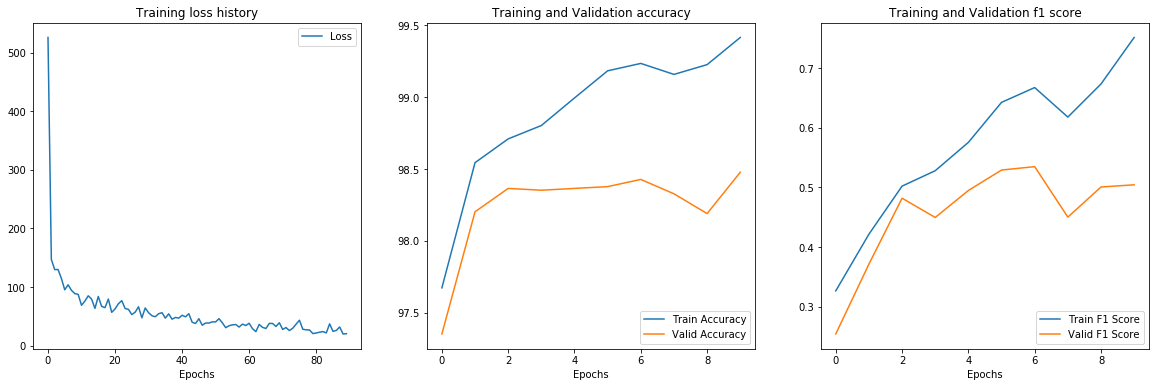

In [0]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].plot(loss_history, label='Loss')
axs[0].title.set_text("Training loss history")
axs[0].legend(loc="upper right")
axs[0].set_xlabel("Epochs")
axs[1].plot(train_acc, label='Train Accuracy')
axs[1].plot(val_acc, label='Valid Accuracy')
axs[1].title.set_text("Training and Validation accuracy")
axs[1].legend(loc="lower right")
axs[1].set_xlabel("Epochs")
axs[2].plot(train_f1_score, label='Train F1 Score')
axs[2].plot(val_f1_score, label='Valid F1 Score')
axs[2].title.set_text("Training and Validation f1 score")
axs[2].legend(loc="lower right")
axs[2].set_xlabel("Epochs")